## New York Health Care Claims Reports 2022

Here we analyze the New York State ealth care claims reports corresponding to plan years 2022.

At the time of writing, the following links host and provide information about these reports:
- https://www.dfs.ny.gov/reports_and_publications/health_care_claim_reports
- https://www.dfs.ny.gov/apps_and_licensing/health_care_claim_reports

### Setup

In [5]:
import hashlib
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sys.path.append("../..")

from src.utils.data.clean_and_parse import cast_to_int, cast_to_float
from src.utils.download import download_file_from_url
from src.utils.plot import (
    plot_bar,
    plot_pie,
    heatmap,
    heatmap_from_df_cols,
    PRIMARY_CMAP,
)

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ny_claim_reports"
OUTPUT_DATA_DIR = "./output_data/ny_claim_reports"  # Set to None if you don't want to save non-required data for external use

os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [6]:
# DL utilities
def scrape_table_from_url(url):
    # Send a GET request to the URL
    response = requests.get(url)

    if response.status_code != 200:
        # If the request was not successful, raise an exception
        raise Exception(f"Error accessing URL: {response.status_code}")

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table element(s) in the HTML
    table = soup.find("table")

    if not table:
        # If no table was found, raise an exception or return None
        raise Exception("No table found on the page")

    # Process the table data and extract the rows and columns
    rows = table.find_all("tr")
    table_data = {}

    for row in rows:
        columns = row.find_all("td")
        if len(columns) == 0:
            continue
        row_name = columns[0].text.strip()
        row_data = columns[-1].find("a").get("href")
        table_data[row_name] = {}
        table_data[row_name]["url"] = "https://www.dfs.ny.gov" + row_data

    return table_data


import shutil


def download_file(url, fname):
    local_filename = url.split("/")[-1]
    with requests.get(url, stream=True) as r:
        with open(fname, "wb") as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename

### Download Raw Data

In [7]:
# Scrape for Relevant links
claims_report_links = scrape_table_from_url(
    "https://www.dfs.ny.gov/reports_and_publications/health_care_claim_reports_2022"
)

In [8]:
# Download all files, and store their hashes and local paths
for key in claims_report_links:
    url = claims_report_links[key]["url"]
    file_path = os.path.join(INPUT_DATA_DIR, f"{key}.xlsx")

    if not os.path.exists(file_path):
        download_file(url, fname=file_path)

    # Copied from: https://stackoverflow.com/questions/22058048/hashing-a-file-in-python/22058673#22058673
    def sha256sum(filename):
        h = hashlib.sha256()
        b = bytearray(128 * 1024)
        mv = memoryview(b)
        with open(filename, "rb", buffering=0) as f:
            for n in iter(lambda: f.readinto(mv), 0):
                h.update(mv[:n])
        return h.hexdigest()

    file_hash = sha256sum(file_path)
    claims_report_links[key]["file_hash"] = file_hash
    claims_report_links[key]["file_path"] = file_path

In [9]:
claims_report_links

{'4 Ever Life Insurance Company': {'url': 'https://www.dfs.ny.gov/reports_and_publications/hc_claim_reports/2022annual/4everlife_80985',
  'file_hash': 'a429cc6213b2b80149262ef80ef67693560af85bf415827a19a829abf85c7bb1',
  'file_path': './input_data/4 Ever Life Insurance Company.xlsx'},
 'Aetna Health Insurance Company of New York': {'url': 'https://www.dfs.ny.gov/reports_and_publications/hc_claim_reports/2022annual/aetna_health_ins_84450',
  'file_hash': 'e8df81f755c8dd1703eb45400b341260ab0cca62b3c7200362639cc28bd5e427',
  'file_path': './input_data/Aetna Health Insurance Company of New York.xlsx'},
 'Aetna Life Insurance Company': {'url': 'https://www.dfs.ny.gov/reports_and_publications/hc_claim_reports/2022annual/aetna_life_60054',
  'file_hash': '74f9438637ee87e3c78292c7d83779ea95c10ac4187a58eee6048d9e4e12c493',
  'file_path': './input_data/Aetna Life Insurance Company.xlsx'},
 "Capital District Physicians' Health Plan, Inc. (CDPHP)": {'url': 'https://www.dfs.ny.gov/reports_and_publ

### NYS Annual Reports Template parsing


In [11]:
# Note: legend says all instances of 0 mean no data! Not sure if this means unknown, or no data as in no (zero) claims.
VALIDATION_TOLERANCE = 5

In [12]:
def extract_claims_df(
    df: pd.DataFrame,
    validate: bool = True,
    validation_tolerance: int = VALIDATION_TOLERANCE,
) -> pd.DataFrame:
    # Extract claims df of interest

    # Isolate rows and cols of interest, transpose
    claim_data = df.iloc[6:26]
    claim_data = claim_data.iloc[:, 2:11].T.reset_index(drop=True)

    # Set col names
    claim_data.columns = claim_data.iloc[0]
    claim_data = claim_data.tail(-1)

    # Reset cols
    mapper = {
        "Major Category of Health Care Provider": "provider_category",
        "# of Claims Received during the Current Reporting Period": "new_claims_recvd",
        "$ Value of Claims Received during the Current Reporting Period (Billed Charges)": "new_claims_recvd_billed",
        "$ Value of Claims Received during the Current Reporting Period (Allowed Amount)": "new_claims_recvd_allowed",
        "# of Claims Pended at the end of the Prior Reporting Period": "pending_claims_recvd",
        "$ Value of Claims Pended at the end of the Prior Reporting Period (Billed Charges)": "pending_claims_recvd_billed",
        "$ Value of Claims Pended at the end of the Prior Reporting Period (Allowed Amount)": "pending_claims_recvd_allowed",
        "# of Claims Rejected during the Current Reporting Period": "claims_rejected",
        "# of Claims Paid in Full during the Current Reporting Period": "claims_paid",
        "$ Value of Claims Paid in Full during the Current Reporting Period (Billed Charges)": "claims_paid_billed",
        "$ Value of Claims Paid in Full during the Current Reporting Period (Allowed Amount)": "claims_paid_allowed",
        "# of Claims Denied in Full during the Current Reporting Period": "claims_denied",
        "$ Value of Claims Denied in Full during the Current Reporting Period (Billed Charges)": "claims_denied_billed",
        "$ Value of Claims Denied in Full during the Current Reporting Period (Allowed Amount)": "claims_denied_allowed",
        "# of Claims Paid in Part and Denied in Part during the Current Reporting Period": "claims_partially_paid",
        "$ Value of Claims Partially Paid during the Current Reporting Period (Billed Charges)": "claims_partially_paid_billed",
        "$ Value of Claims Partially Paid during the Current Reporting Period (Allowed Amount)": "claims_partially_paid_allowed",
        "$ Value of Claims Partially Denied during the Current Reporting Period (Billed Charges)": "claims_partially_denied_billed",
        "$ Value of Claims Partially Denied during the Current Reporting Period (Allowed Amount)": "claims_partially_denied_allowed",
        "# of Claims Pended at the end of the Current Reporting Period": "claims_left_pending",
    }
    claim_data = claim_data.rename(columns=mapper)

    # Cast dtypes
    int_cols = [
        "new_claims_recvd",
        "pending_claims_recvd",
        "claims_rejected",
        "claims_paid",
        "claims_denied",
        "claims_partially_paid",
        "claims_left_pending",
    ]
    float_cols = [
        "new_claims_recvd_billed",
        "new_claims_recvd_allowed",
        "pending_claims_recvd_billed",
        "pending_claims_recvd_allowed",
        "claims_paid_billed",
        "claims_paid_allowed",
        "claims_denied_billed",
        "claims_denied_allowed",
        "claims_partially_paid_billed",
        "claims_partially_paid_allowed",
        "claims_partially_denied_billed",
        "claims_partially_denied_allowed",
    ]
    claim_data = claim_data.replace(pd.NA, 0)
    # Some conceptually int cols are stored as floats with non-integral parts....very odd
    claim_data[int_cols] = claim_data[int_cols].astype(float).round(0)
    claim_data = cast_to_int(claim_data, cols=int_cols)
    claim_data = cast_to_float(claim_data, cols=float_cols)

    # Sanity check tests
    if validate:
        # Totals are in fact correct for each provider category
        for col in claim_data.columns[1:]:
            # Since conceptual ints are stored as floats with non-integral parts, the sums after rounding are not consistent. Allow tolerance of 1 here.
            assert (
                abs(claim_data[col].values[:-1].sum() - claim_data[col].values[-1])
                <= validation_tolerance
            ), f"Total value for column {col} is not the sum constituents."

        # Claims in = Claims out + Claims processed (in each cat)
        pd.testing.assert_series_equal(
            claim_data["new_claims_recvd"] + claim_data["pending_claims_recvd"],
            (
                claim_data["claims_rejected"]
                + claim_data["claims_paid"]
                + claim_data["claims_denied"]
                + claim_data["claims_partially_paid"]
                + claim_data["claims_left_pending"]
            ),
            atol=VALIDATION_TOLERANCE,
        )

    claim_data["claims_recvd"] = (
        claim_data["new_claims_recvd"] + claim_data["pending_claims_recvd"]
    )

    claim_data["claims_adjudicated"] = (
        claim_data["claims_recvd"] - claim_data["claims_left_pending"]
    )

    # Replace space in Other category
    claim_data = claim_data.replace("Other ", "Other")

    return claim_data

In [13]:
def extract_appeals_df(
    df: pd.DataFrame,
    validate: bool = True,
    validation_tolerance: int = VALIDATION_TOLERANCE,
) -> pd.DataFrame:
    # Extract appeals df of interest

    # Isolate rows and cols of interest, transpose
    appeal_data = df.iloc[34:49]
    appeal_data = appeal_data.iloc[:, 2:11].T.reset_index(drop=True)

    # Set col names
    appeal_data.columns = appeal_data.iloc[0]
    appeal_data = appeal_data.tail(-1)

    # Reset cols
    mapper = {
        "Major Category of Health Care Provider": "provider_category",
        "# of First Level Appeals Received during the Current Reporting Period": "new_internal_appeals",
        "$ Value of Claims Initially Denied in Full or in Part that were submitted for First Level Appeal during the Current Reporting Period (Billed Charges)": "new_internal_appeals_billed",
        "$ Value of Claims Initially Denied in Full or in Part that were submitted for First Level Appeal during the Current Reporting Period (Allowed Charges)": "new_internal_appeals_allowed",
        "# of First Level Appeals Pending at the end of the Prior Reporting Period": "pending_internal_appeals",
        "$ Value of Claims Initially Denied in Full or in Part that were pending First Level Appeal at the end of the Prior Reporting Period (Billed Charges)": "pending_internal_appeals_billed",
        "$ Value of Claims Initially Denied in Full or in Part that were pending First Level Appeal at the end of the Prior Reporting Period (Allowed Amount)": "pending_internal_appeals_allowed",
        "# of First Level Appeals Overturned in Full during the Current Reporting Period": "internal_appeals_overturned",
        "# of First Level Appeals Overturned in Part during the Current Reporting Period": "internal_appeals_partially_overturned",
        "$ Value of Claims Paid in Full or in Part upon First Level Appeal during the Current Reporting Period (Billed Charges)": "internal_appeals_overturned_billed",
        "$ Value of Claims Paid in Full or in Part upon First Level Appeal during the Current Reporting Period (Allowed Amount)": "internal_appeals_overturned_allowed",
        "# of First Level Appeals Upheld during the Current Reporting Period": "internal_appeals_upheld",
        "$ Value of Claims Denied in Full or in Part upon First Level Appeal during the Current Reporting Period (Billed Charges)": "internal_appeals_upheld_billed",
        "$ Value of Claims Denied in Full or in Part upon First Level Appeal during the Current Reporting Period (Allowed Amount)": "internal_appeals_upheld_allowed",
        "# of First Level Appeals Pending at the end of the Current Reporting Period": "internal_appeals_left_pending",
    }
    appeal_data = appeal_data.rename(columns=mapper)

    # Cast dtypes
    int_cols = [
        "new_internal_appeals",
        "pending_internal_appeals",
        "internal_appeals_overturned",
        "internal_appeals_partially_overturned",
        "internal_appeals_upheld",
        "internal_appeals_left_pending",
    ]
    float_cols = [
        "new_internal_appeals_billed",
        "new_internal_appeals_allowed",
        "pending_internal_appeals_billed",
        "pending_internal_appeals_allowed",
        "internal_appeals_overturned_billed",
        "internal_appeals_overturned_allowed",
        "internal_appeals_upheld_billed",
        "internal_appeals_upheld_allowed",
    ]

    appeal_data = appeal_data.replace(pd.NA, 0)
    appeal_data = cast_to_int(appeal_data, cols=int_cols)
    appeal_data = cast_to_float(appeal_data, cols=float_cols)

    # Sanity check test
    if validate:
        # totals
        accounted_cols = [
            "pending_internal_appeals",
            "new_internal_appeals",
            "internal_appeals_overturned",
            "internal_appeals_partially_overturned",
            "internal_appeals_upheld",
            "internal_appeals_left_pending",
        ]
        for col in accounted_cols:
            assert (
                abs(appeal_data[col].values[:-1].sum() - appeal_data[col].values[-1])
                <= validation_tolerance
            ), f"Total value for column {col} is not the sum constituents."

        # Appeals in = appeals out + appeals processed (in each cat)
        pd.testing.assert_series_equal(
            appeal_data["new_internal_appeals"]
            + appeal_data["pending_internal_appeals"],
            (
                appeal_data["internal_appeals_overturned"]
                + appeal_data["internal_appeals_partially_overturned"]
                + appeal_data["internal_appeals_upheld"]
                + appeal_data["internal_appeals_left_pending"]
            ),
        )

    appeal_data["internal_appeals_recvd"] = (
        appeal_data["new_internal_appeals"] + appeal_data["pending_internal_appeals"]
    )

    appeal_data["internal_appeals_adjudicated"] = (
        appeal_data["internal_appeals_recvd"]
        - appeal_data["internal_appeals_left_pending"]
    )

    # Replace space in Other category
    appeal_data = appeal_data.replace("Other ", "Other")

    return appeal_data

In [14]:
def extract_denial_rationales(df: pd.DataFrame, validate: bool = True) -> pd.DataFrame:
    # Extract denial rationales df of interest

    # Isolate rows and cols of interest, transpose
    df = df.iloc[58:].reset_index(drop=True)

    # Set col names
    df.columns = df.iloc[0]
    df = df.tail(-1).reset_index(drop=True)

    # Get NMN billed, allowed amts, total billed, allowed amts in each provider category
    nmn_billed = []
    nmn_allowed = []
    total_billed = []
    total_allowed = []
    for idx, row in df.iterrows():
        if idx % 3 == 1:
            nmn_billed.append(
                row[
                    "Not medically necessary (including experimental/investigational, clinical trial, rare disease)"
                ]
            )
            total_billed.append(row["Total"])
            df.drop(idx, inplace=True)
        if idx % 3 == 2:
            nmn_allowed.append(
                row[
                    "Not medically necessary (including experimental/investigational, clinical trial, rare disease)"
                ]
            )
            total_allowed.append(row["Total"])
            df.drop(idx, inplace=True)

    df["claims_denied_nmn_billed"] = nmn_billed
    df["claims_denied_nmn_allowed"] = nmn_allowed
    df["claims_denied_billed_t3"] = total_billed
    df["claims_denied_allowed_t3"] = total_allowed
    df = df.reset_index(drop=True)

    df = df.drop(columns=["Line", "Claim Denial Reasons"])

    mapper = {
        "Provider Category": "provider_category",
        "Not medically necessary (including experimental/investigational, clinical trial, rare disease)": "claims_denied_nmn_exp",
        "Non-formulary drug": "claims_denied_formulary",
        "Step therapy denial": "claims_denied_step",
        "Not a covered benefit/Exceeds benefit limits (e.g., visit limits)": "claims_denied_not_covered",
        "Failure of provider to request preauthorization": "claims_denied_auth",
        "Provider not in-network (no OON coverage)": "claims_denied_oon",
        "Member's coverage not in effect at time of service": "claims_denied_effective",
        "Claim not timely": "claims_denied_timely",
        "Duplicate Claim": "claims_denied_duplicate",
        "Coding issue": "claims_denied_coding",
        "Other": "claims_denied_other",
        "Total": "claims_denied_t3",
        "claims_denied_nmn_billed": "claims_denied_nmn_billed",
        "claims_denied_nmn_allowed": "claims_denied_nmn_allowed",
        "claims_denied_billed2": "claims_denied_billed_t3",
        "claims_denied_allowed2": "claims_denied_allowed_t3",
    }
    df = df.rename(columns=mapper)

    # Cast dtypes
    int_cols = [
        "claims_denied_nmn_exp",
        "claims_denied_formulary",
        "claims_denied_step",
        "claims_denied_not_covered",
        "claims_denied_auth",
        "claims_denied_oon",
        "claims_denied_effective",
        "claims_denied_timely",
        "claims_denied_duplicate",
        "claims_denied_coding",
        "claims_denied_other",
        "claims_denied_t3",
    ]
    float_cols = [
        "claims_denied_nmn_billed",
        "claims_denied_nmn_allowed",
        "claims_denied_billed_t3",
        "claims_denied_allowed_t3",
    ]

    df = df.replace(pd.NA, 0)
    df = cast_to_int(df, cols=int_cols)
    df = cast_to_float(df, cols=float_cols)

    # Update Other Facilities provider cat
    df = df.replace("Other Facilities - Inpatient", "Other Facilities")

    return df

In [15]:
def construct_insurer_df(df: pd.DataFrame, validate: bool = True) -> pd.DataFrame:
    claim_data = extract_claims_df(df, validate)
    appeal_data = extract_appeals_df(df, validate)
    rationale_df = extract_denial_rationales(df, validate)

    insurer_df = claim_data.merge(appeal_data, on=["provider_category"]).merge(
        rationale_df, on=["provider_category"]
    )

    # How to explain discrepancy between claims_denied, claims_denied_t3?

    # Possible explanations

    # From NYS FAQ:
    # Claims should be counted only under one denial reason on Table 3.
    # If any one of the denial reasons is “not medically necessary,” the claim should be counted there.
    # For all other denial reasons, the issuer should determine the primary reason and count the claim denial once.

    # Maybe misreported by insurers who neglected the FAQ, though?

    # Insurers are counting appealed and overturned denials differently in tables 2 and 3

    # A claim that is denied during the reporting period should be counted on lines 11 or 13 even if
    # the claim was subsequently overturned on appeal during that reporting period. A claim that is overturned
    # upon appeal during the reporting period should be accounted for on Table 2.

    # Best guess:
    # Claims denied on T3 includes partial and full denials. We expect partial and full denial counts
    # from T1 should sum to a value geq than this row on T3 (because occasionally denial rationales won't be provided, or cannot be....)
    if validate:
        if not (
            insurer_df["claims_denied"] + insurer_df["claims_partially_paid"]
            >= insurer_df["claims_denied_t3"]
        ).all():
            raise ValueError(
                "\t Rationale df inconsistent with denial df. claims denied + claims partially paid != claims_denied_t3"
            )
    return insurer_df

In [16]:
# Constuct global map from insurers to NAIC and relevant commercial claims DF
commercial = {}

# Loop over insurer files
for key, val in claims_report_links.items():
    file_ref = pd.ExcelFile(val["file_path"])
    df = pd.read_excel(file_ref, sheet_name="Commercial")

    name = df.columns[1]
    commercial[name] = {}

    naic_num = df.iloc[0][1]
    commercial[name]["naic_company_code"] = naic_num

    try:
        claims_df = construct_insurer_df(df)
        commercial[name]["claims_df"] = claims_df
        commercial[name]["validated"] = True
    except ValueError as e:
        claims_df = construct_insurer_df(df, validate=False)
        commercial[name]["claims_df"] = claims_df
        commercial[name]["validated"] = False
        print(
            f"File for {key} has denial data is inconsistent with denial rationale data."
        )

File for 4 Ever Life Insurance Company has denial data is inconsistent with denial rationale data.
File for Cigna Health and Life Insurance Company has denial data is inconsistent with denial rationale data.
File for Connecticut General Life Insurance Company (Cigna) has denial data is inconsistent with denial rationale data.
File for EmblemHealth Insurance Company has denial data is inconsistent with denial rationale data.
File for Emblem Health Plan, Inc. has denial data is inconsistent with denial rationale data.
File for Empire Healthchoice Assurance, Inc. has denial data is inconsistent with denial rationale data.
File for Empire Healthchoice HMO, Inc. has denial data is inconsistent with denial rationale data.
File for Health Insurance Plan of Greater New York (HIP) has denial data is inconsistent with denial rationale data.
File for HealthPlus HP, LLC has denial data is inconsistent with denial rationale data.
File for Highmark Western and Northeastern New York, Inc. (formerly H

# High Level Stats

In [17]:
# Construct a single df for convenience
dfs = []
for key, val in commercial.items():
    df = val["claims_df"]
    df["naic_code"] = val["naic_company_code"]
    df["validated"] = val["validated"]
    df["insurer_name"] = key
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

In [18]:
print(f"This dataset contains:\n")
print(f"\t {len(df['naic_code'].unique())} insurers.")
print(
    f"\t {df['claims_adjudicated'].sum():,} claims adjudicated, worth at least ${int(df['new_claims_recvd_allowed'].sum() + df['pending_claims_recvd_allowed'].sum()):,}."
)
print(
    f"\t {df['claims_denied'].sum():,} claims denied, worth at least ${int(df['claims_denied_allowed'].sum()):,}."
)
print(
    f"\t {df['claims_denied_nmn_exp'].sum():,} claims denied for medical necessity, worth at least ${int(df['claims_denied_nmn_allowed'].sum()):,}."
)
print(
    f"\t {df['internal_appeals_adjudicated'].sum():,} internal appeals adjudicated, worth at least ${int((df['new_internal_appeals_allowed'].sum() + df['pending_internal_appeals_allowed'].sum())):,}."
)
print(
    f"\t {df['internal_appeals_overturned'].sum():,} internal appeals overturned, worth at least ${int(df['internal_appeals_overturned_allowed'].sum()):,}."
)

This dataset contains:

	 29 insurers.
	 145,446,802 claims adjudicated, worth at least $66,810,881,848.
	 25,996,601 claims denied, worth at least $2,265,844,512.
	 177,917 claims denied for medical necessity, worth at least $35,747,594.
	 145,129 internal appeals adjudicated, worth at least $303,942,639.
	 42,375 internal appeals overturned, worth at least $124,245,612.


In [19]:
def get_denial_rate(row, recvd_col="claims_adjudicated", denied_col="claims_denied"):
    recvd = row[recvd_col]
    denied = row[denied_col]
    if recvd == 0:
        return -1
    if type(recvd) is str and type(denied) is str:
        return int(denied) / int(recvd)
    if type(recvd) is int and type(denied) is int:
        return denied / recvd
    else:
        return -1


def get_int_appeal_rate(
    row, denied_col="claims_denied", appealed_col="internal_appeals_adjudicated"
):
    appealed = row[appealed_col]
    denied = row[denied_col]
    if denied == 0:
        return -1
    if type(appealed) is str and type(denied) is str:
        return int(appealed) / int(denied)
    if type(appealed) is int and type(denied) is int:
        return appealed / denied
    else:
        return -1


def get_int_appeal_overturn_rate(
    row,
    recvd_col="internal_appeals_adjudicated",
    overturned_col="internal_appeals_overturned",
):
    recvd = row[recvd_col]
    overturned = row[overturned_col]
    if recvd == 0:
        return -1
    if type(recvd) is str and type(overturned) is str:
        return int(overturned) / int(recvd)
    if type(recvd) is int and type(overturned) is int:
        return overturned / recvd
    else:
        return -1

In [20]:
# Add overall (complete) denial rate by provider category, by insurer
df["denial_rate"] = df.apply(get_denial_rate, axis=1)

# Calculate (complete) denial rate, by provider category, summed across insurers

total_adjudicated = df["claims_adjudicated"].sum()
total_denied = df["claims_denied"].sum()
total_denial_rate = total_denied / total_adjudicated
print(
    f"Aggregate denial rate across all insurers (summed counts): {100*total_denial_rate:.2f}%"
)


total_appealed = df["internal_appeals_adjudicated"].sum()
total_appeal_rate = total_appealed / total_denied
print(
    f"Aggregate appeal rate across all insurers (summed counts): {100*total_appeal_rate:.2f}%"
)

total_overturned = df["internal_appeals_overturned"].sum()
total_overturn_rate = total_overturned / total_appealed
print(
    f"Aggregate appeal overturn rate across all insurers (summed counts): {100*total_overturn_rate:.2f}%"
)

Aggregate denial rate across all insurers (summed counts): 17.87%
Aggregate appeal rate across all insurers (summed counts): 0.56%
Aggregate appeal overturn rate across all insurers (summed counts): 29.20%


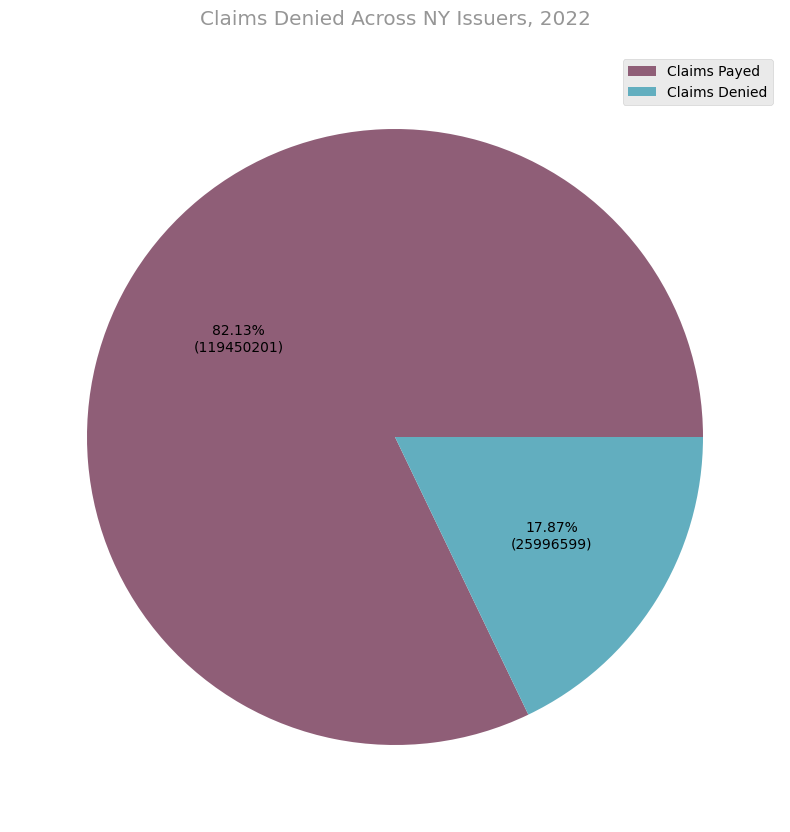

In [21]:
# Initial denial rate
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_adjudicated - total_denied, total_denied],
    title="Claims Denied Across NY Issuers, 2022",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie.png"),
)

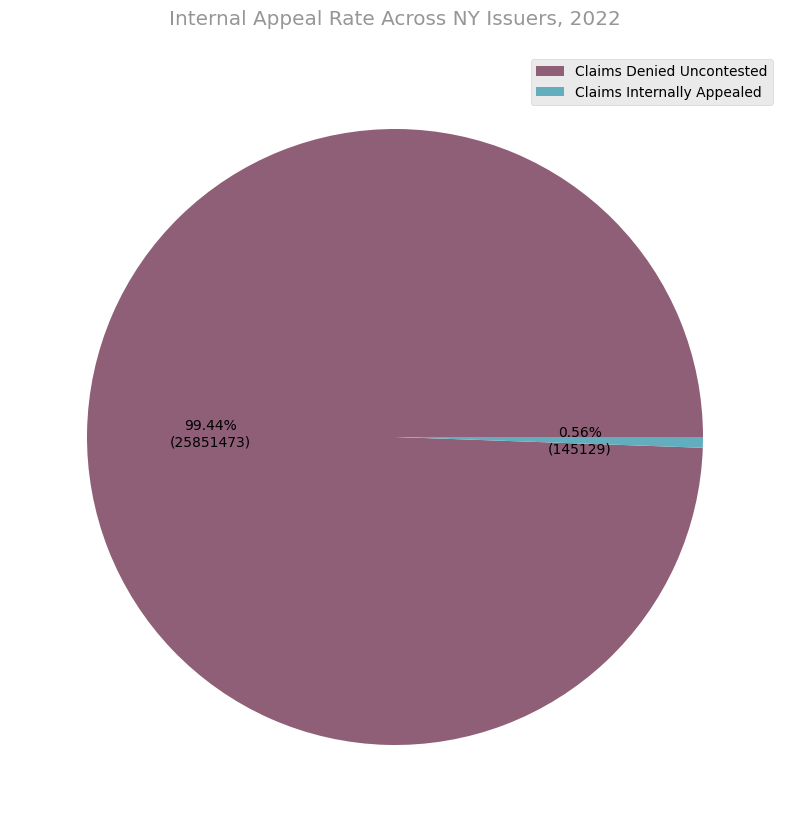

In [22]:
# Initial appeal rate
plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[total_denied - total_appealed, total_appealed],
    title="Internal Appeal Rate Across NY Issuers, 2022",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_pie.png"),
)

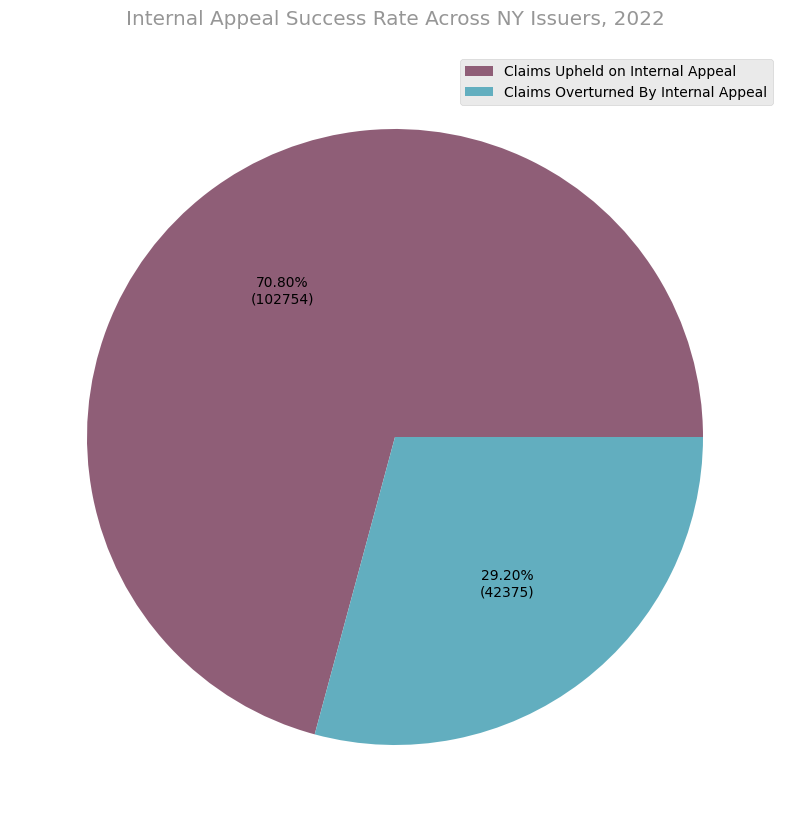

In [23]:
# Initial appeal success rate
plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned By Internal Appeal",
    ],
    slice_vals=[total_appealed - total_overturned, total_overturned],
    title="Internal Appeal Success Rate Across NY Issuers, 2022",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_overturns_pie.png"),
)

In [24]:
# Construct two aggregate dfs:

# Collapse provider categories for each insurer (resulting in one row per insurer with all provider cats lumped):
provider_agg = df.groupby(["provider_category"]).sum(numeric_only=True).reset_index()
provider_agg["denial_rate"] = provider_agg.apply(get_denial_rate, axis=1)
provider_agg["internal_appeal_rate"] = provider_agg.apply(get_int_appeal_rate, axis=1)
provider_agg["internal_appeal_success_rate"] = provider_agg.apply(
    get_int_appeal_overturn_rate, axis=1
)

# Collapse insurers (resulting in one row per provider category with all insurer records in that cat lumped):
insurer_agg = (
    df.groupby(["naic_code", "insurer_name"]).sum(numeric_only=True).reset_index()
)
insurer_agg["denial_rate"] = insurer_agg.apply(get_denial_rate, axis=1)
insurer_agg["internal_appeal_rate"] = insurer_agg.apply(get_int_appeal_rate, axis=1)
insurer_agg["internal_appeal_success_rate"] = insurer_agg.apply(
    get_int_appeal_overturn_rate, axis=1
)

### Denial rates by category

In [25]:
provider_cats = list(provider_agg["provider_category"].values)
denial_rates = list(provider_agg["denial_rate"].values)
appeal_rates = list(provider_agg["internal_appeal_rate"].values)
appeal_success_rates = list(provider_agg["internal_appeal_success_rate"].values)

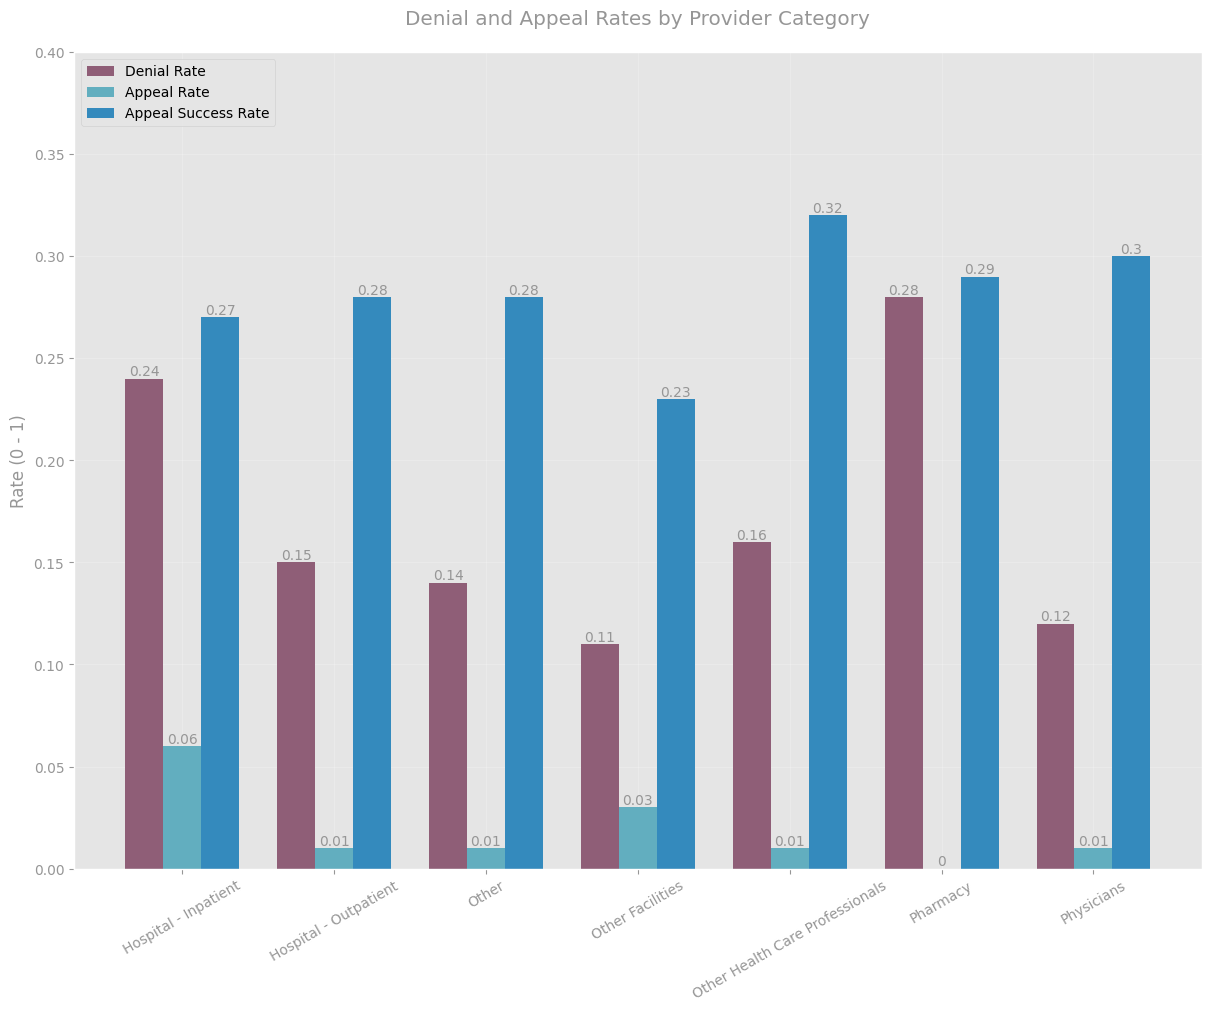

In [26]:
provider_cat_rates = {
    "Denial Rate": [round(x, 2) for x in denial_rates],
    "Appeal Rate": [round(x, 2) for x in appeal_rates],
    "Appeal Success Rate": [round(x, 2) for x in appeal_success_rates],
}

x = np.arange(len(provider_cats))  # label locations
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(12, 10))

for attribute, measurement in provider_cat_rates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=0)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Rate (0 - 1)")
ax.set_title("Denial and Appeal Rates by Provider Category")
ax.set_xticks(x + width, provider_cats, rotation=30)
ax.legend(loc="upper left", ncols=1, labelcolor="black")
ax.set_ylim(0, 0.4)
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "denial_and_appeal_rates_by_provider_cat.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

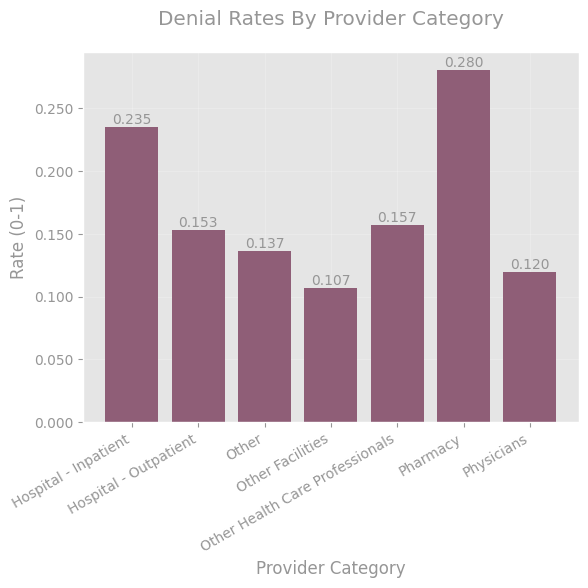

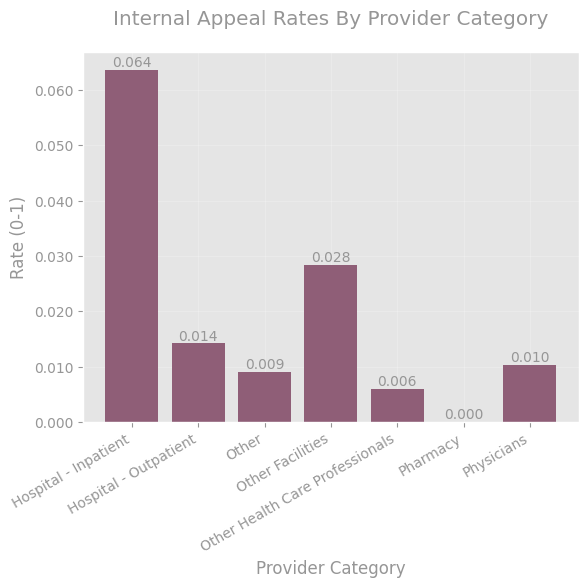

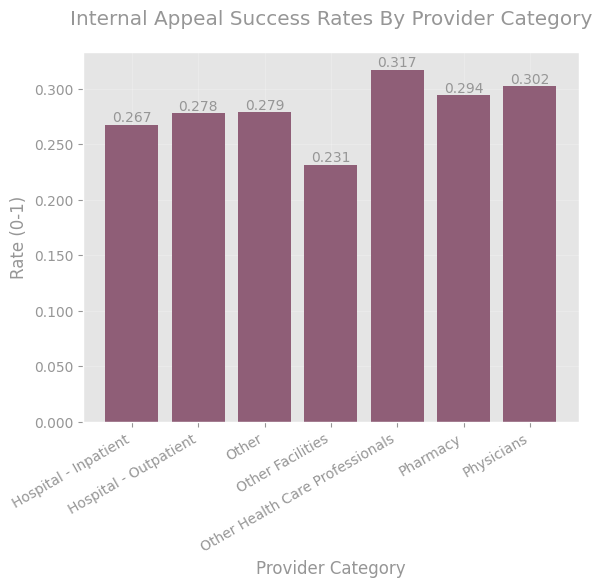

In [27]:
# Split out as three bar plots, above is ugly

bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["denial_rate"].values)
val_axis_label = "Rate (0-1)"
cat_axis_label = "Provider Category"
title = "Denial Rates By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rates_by_provider_cat.png"),
    bar_label=True,
    int_vals=False,
)


bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["internal_appeal_rate"].values)
val_axis_label = "Rate (0-1)"
cat_axis_label = "Provider Category"
title = "Internal Appeal Rates By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_rates_by_provider_cat.png"
    ),
    bar_label=True,
    int_vals=False,
)

bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["internal_appeal_success_rate"].values)
val_axis_label = "Rate (0-1)"
cat_axis_label = "Provider Category"
title = "Internal Appeal Success Rates By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_success_rates_by_provider_cat.png"
    ),
    bar_label=True,
    int_vals=False,
)

In [28]:
# Corresponding plot but with raw counts for relative significance perspective
provider_cats = list(provider_agg["provider_category"].values)
claims = list(provider_agg["claims_adjudicated"].values)
denials = list(provider_agg["claims_denied"].values)
appeals = list(provider_agg["internal_appeals_adjudicated"].values)
overturned_appeals = list(provider_agg["internal_appeals_overturned"].values)

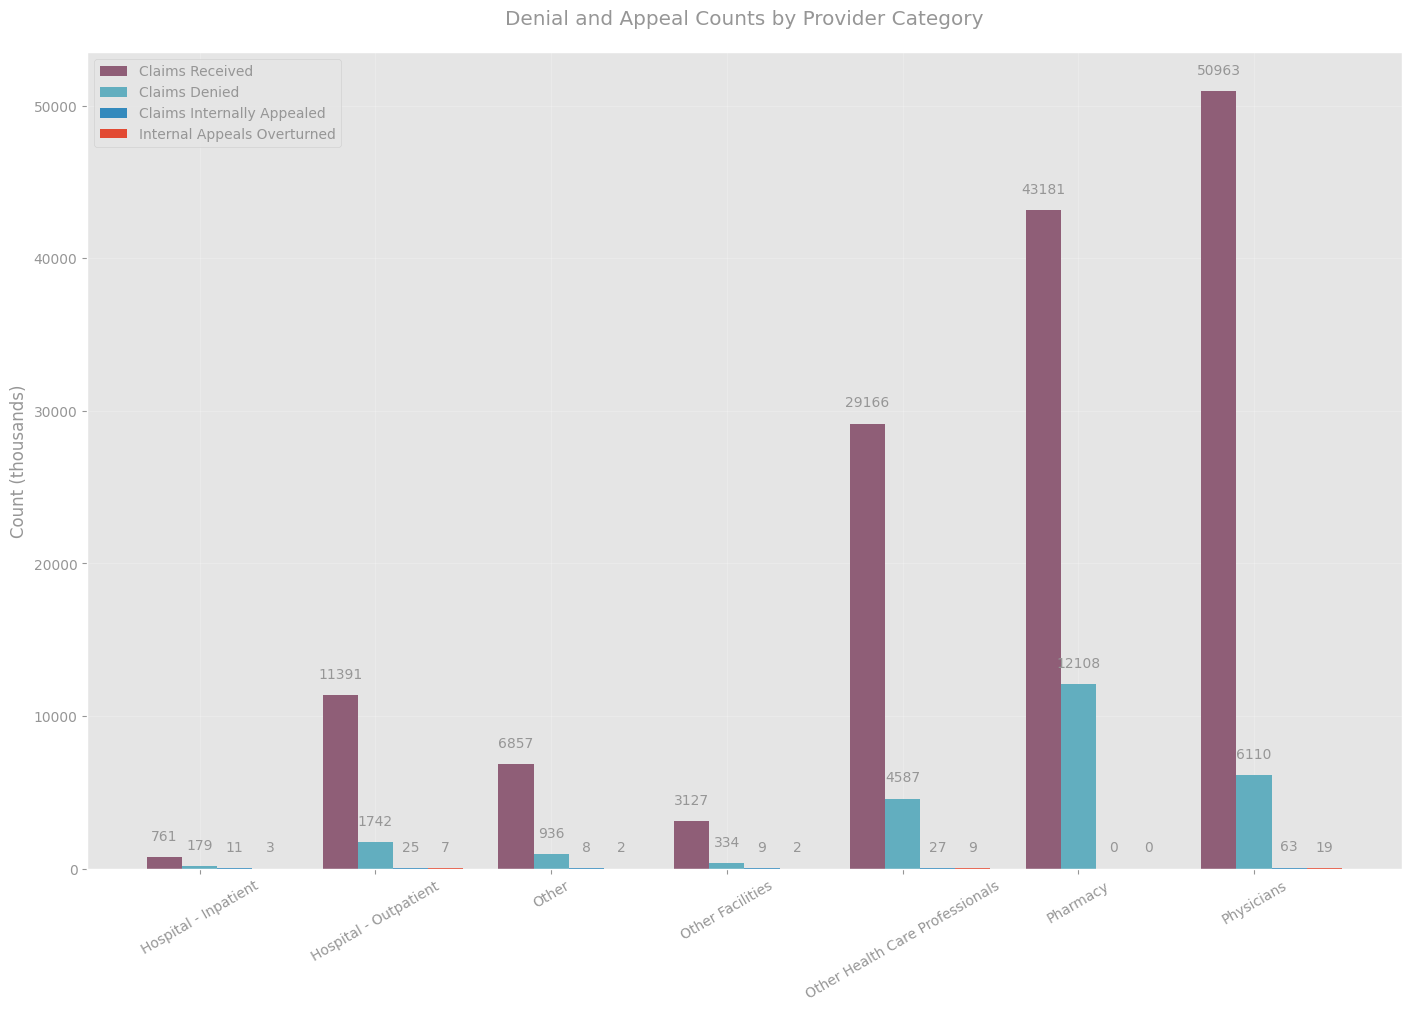

In [29]:
provider_cat_rates = {
    "Claims Received": [round(x / 1000) for x in claims],
    "Claims Denied": [round(x / 1000) for x in denials],
    "Claims Internally Appealed": [round(x / 1000) for x in appeals],
    "Internal Appeals Overturned": [round(x / 1000) for x in overturned_appeals],
}

x = np.arange(len(provider_cats))  # label locations
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(14, 10))

for attribute, measurement in provider_cat_rates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=10)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Count (thousands)")
ax.set_title("Denial and Appeal Counts by Provider Category")
ax.set_xticks(x + width, provider_cats, rotation=30)
ax.legend(loc="upper left", ncols=1)
# ax.set_ylim(0, .4)

plt.show()

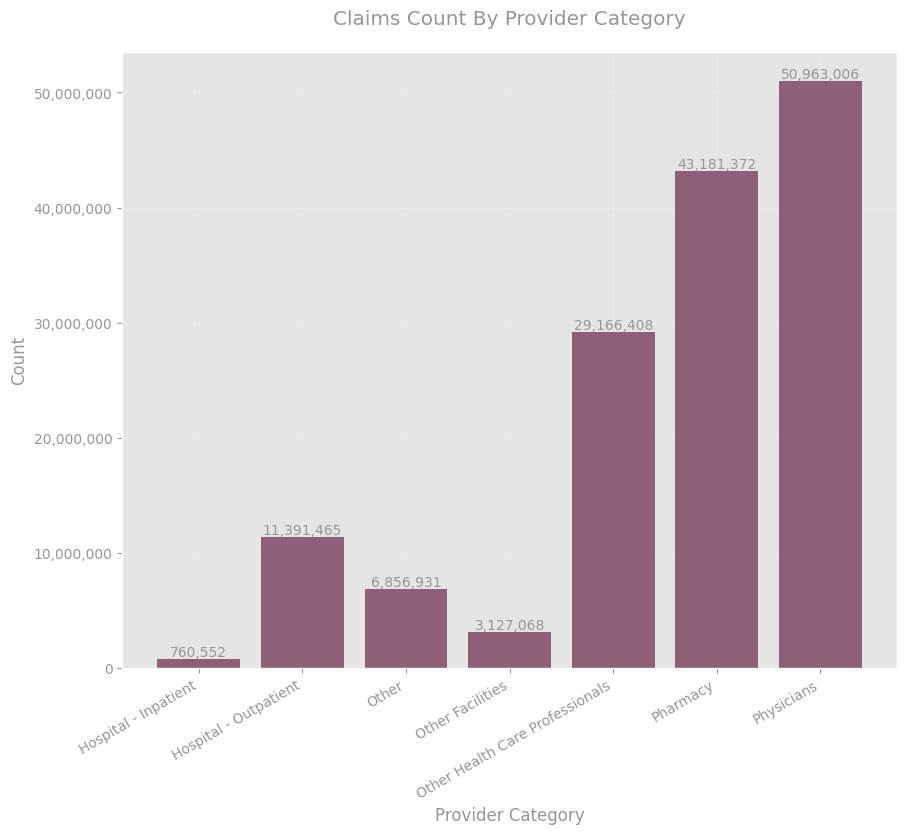

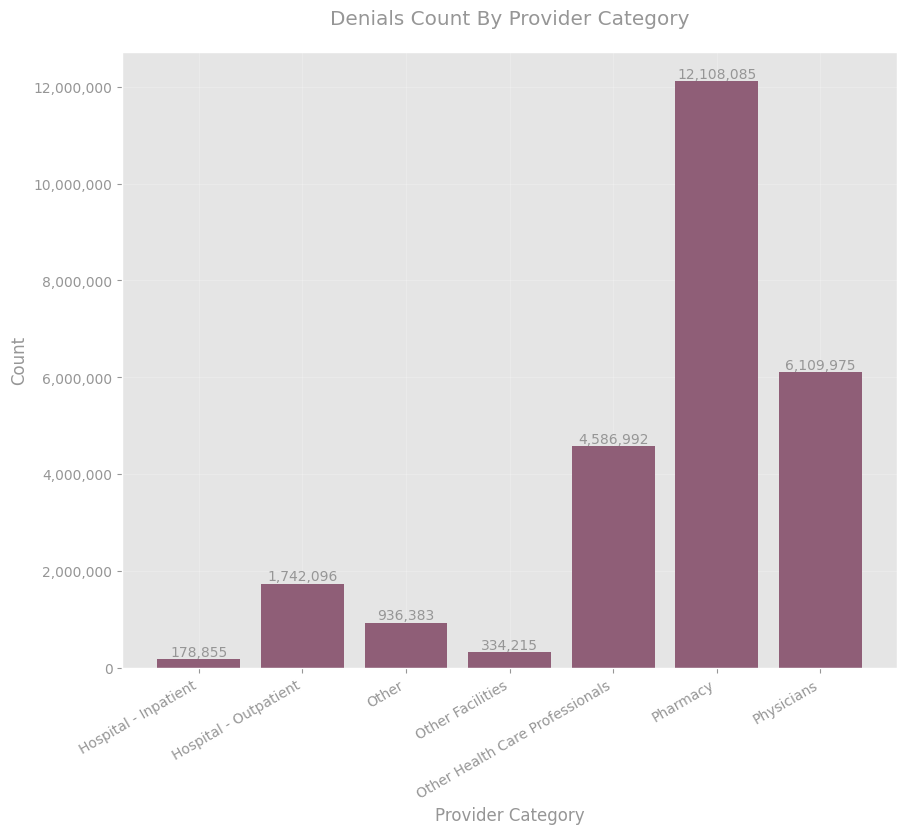

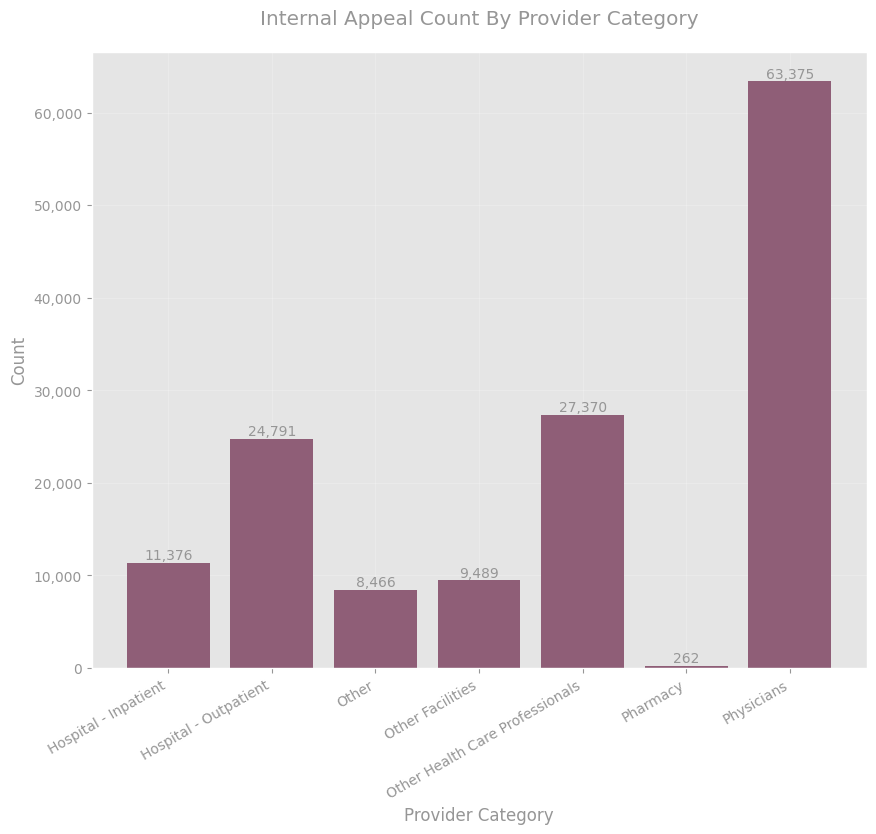

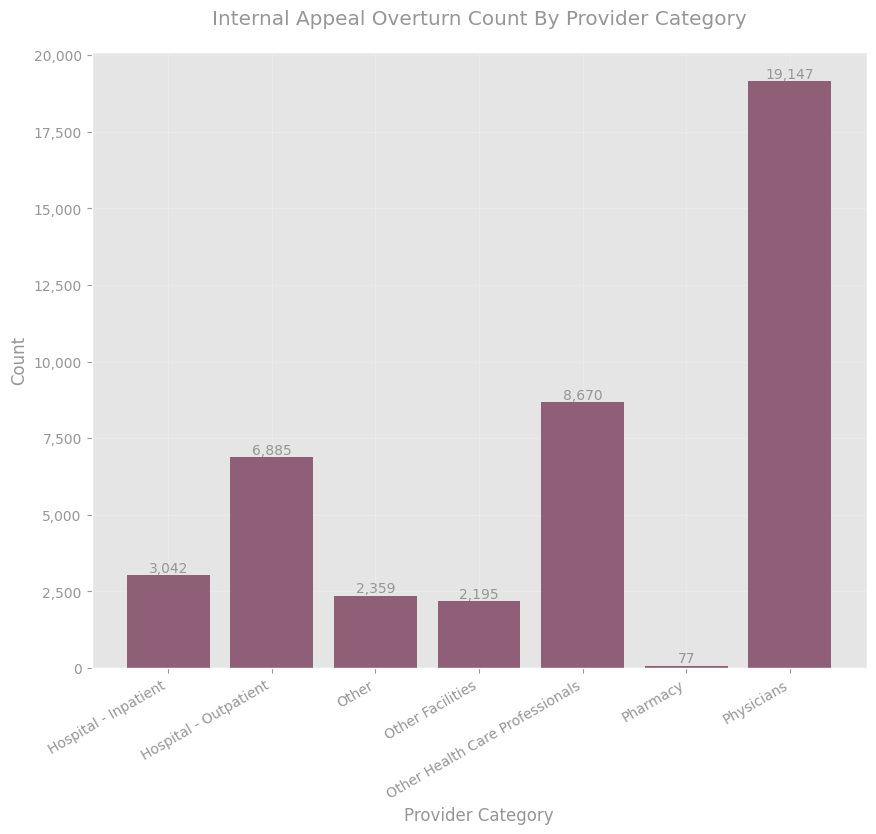

In [30]:
# Split out as three bar plots, above is ugly

bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["claims_adjudicated"].values)
val_axis_label = "Count"
cat_axis_label = "Provider Category"
title = "Claims Count By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "claims_by_provider_cat.png"),
    bar_label=True,
    int_vals=True,
    figsize=(10, 8),
)


bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["claims_denied"].values)
val_axis_label = "Count"
cat_axis_label = "Provider Category"
title = "Denials Count By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denials_by_provider_cat.png"),
    bar_label=True,
    int_vals=True,
    figsize=(10, 8),
)


bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["internal_appeals_adjudicated"].values)
val_axis_label = "Count"
cat_axis_label = "Provider Category"
title = "Internal Appeal Count By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeals_by_provider_cat.png"),
    bar_label=True,
    int_vals=True,
    figsize=(10, 8),
)

bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["internal_appeals_overturned"].values)
val_axis_label = "Count"
cat_axis_label = "Provider Category"
title = "Internal Appeal Overturn Count By Provider Category"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_overturns_by_provider_cat.png"),
    bar_label=True,
    int_vals=True,
    figsize=(10, 8),
)

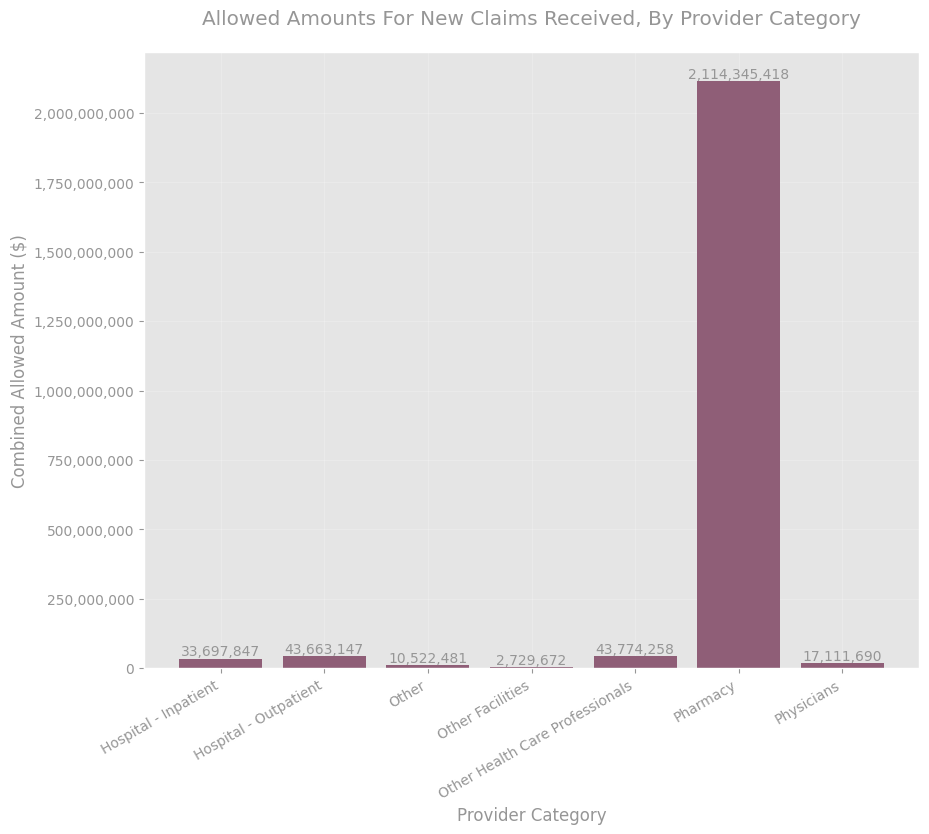

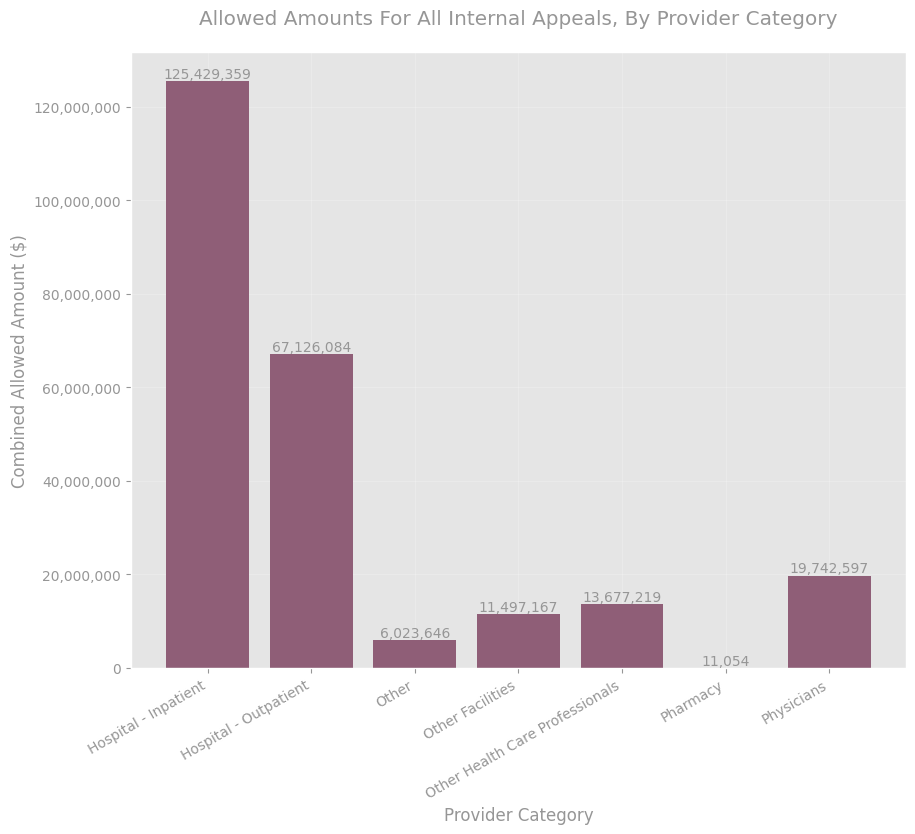

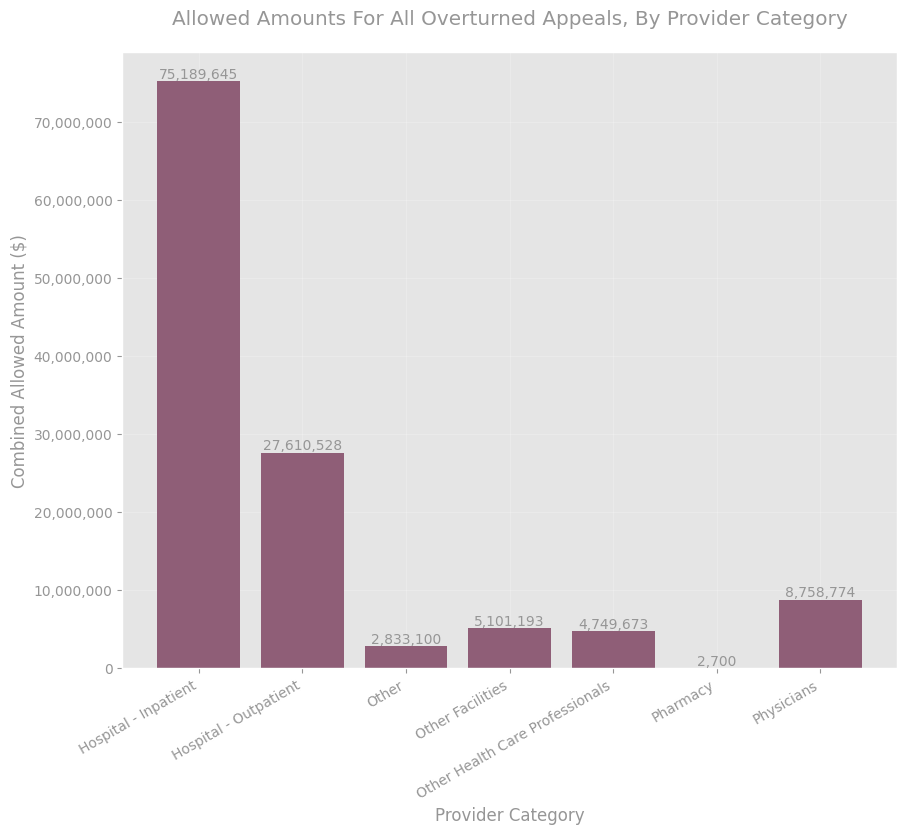

In [31]:
# Total Allowed Amounts of Denials (by cat)
bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["claims_denied_allowed"].values)
title = f"Allowed Amounts For New Claims Received, By Provider Category"
val_axis_label = "Combined Allowed Amount ($)"
cat_axis_label = "Provider Category"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "allowed_amts_denied_by_provider_cat.png"),
    figsize=(10, 8),
)

# Total Allowed Amounts of Appeals (by cat)
bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(
    (
        provider_agg["internal_appeals_upheld_allowed"]
        + provider_agg["internal_appeals_overturned_allowed"]
    ).values
)
title = f"Allowed Amounts For All Internal Appeals, By Provider Category"
val_axis_label = "Combined Allowed Amount ($)"
cat_axis_label = "Provider Category"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "allowed_amts_appealed_by_provider_cat.png"
    ),
    figsize=(10, 8),
)

# Total Allowed Amounts of Overturns (by cat)
bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["internal_appeals_overturned_allowed"].values)
title = f"Allowed Amounts For All Overturned Appeals, By Provider Category"
val_axis_label = "Combined Allowed Amount ($)"
cat_axis_label = "Provider Category"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "allowed_amts_overturned_by_provider_cat.png"
    ),
    figsize=(10, 8),
)

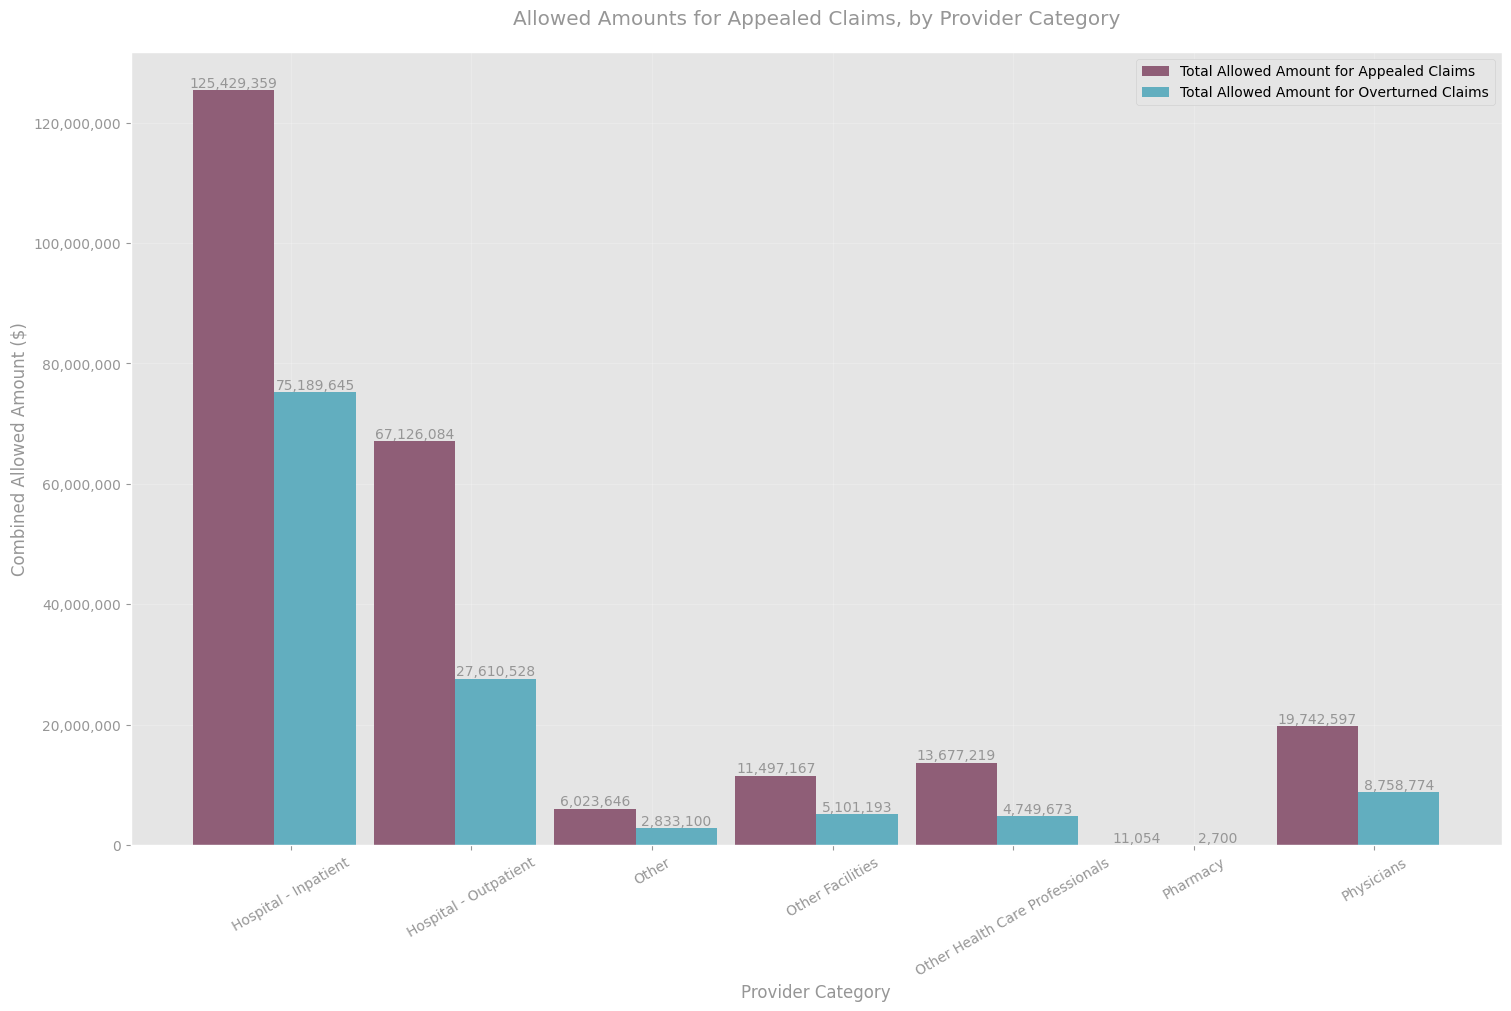

In [32]:
# Same data, stacked
provider_allowed_amts = {
    "Total Allowed Amount for Appealed Claims": list(
        (
            provider_agg["internal_appeals_upheld_allowed"]
            + provider_agg["internal_appeals_overturned_allowed"]
        ).values
    ),
    "Total Allowed Amount for Overturned Claims": list(
        provider_agg["internal_appeals_overturned_allowed"].values
    ),
}
x = np.arange(len(provider_cats))  # label locations
width = 0.45
multiplier = 0.3

fig, ax = plt.subplots(layout="constrained", figsize=(15, 10))

for attribute, measurement in provider_allowed_amts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=0, fmt="{:,.0f}")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel("Combined Allowed Amount ($)")
ax.set_xlabel("Provider Category")
ax.set_title("Allowed Amounts for Appealed Claims, by Provider Category")
ax.set_xticks(x + width, provider_cats, rotation=30)
y_tick_fmt = lambda x: f"{int(x):,}"
ax.set_yticks(ax.get_yticks()[:-1], [y_tick_fmt(x) for x in ax.get_yticks()[:-1]])
ax.legend(loc="upper right", ncols=1, labelcolor="black")
# ax.set_ylim(0, 0.4)
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "allowed_amts_by_provider_category_stacked.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

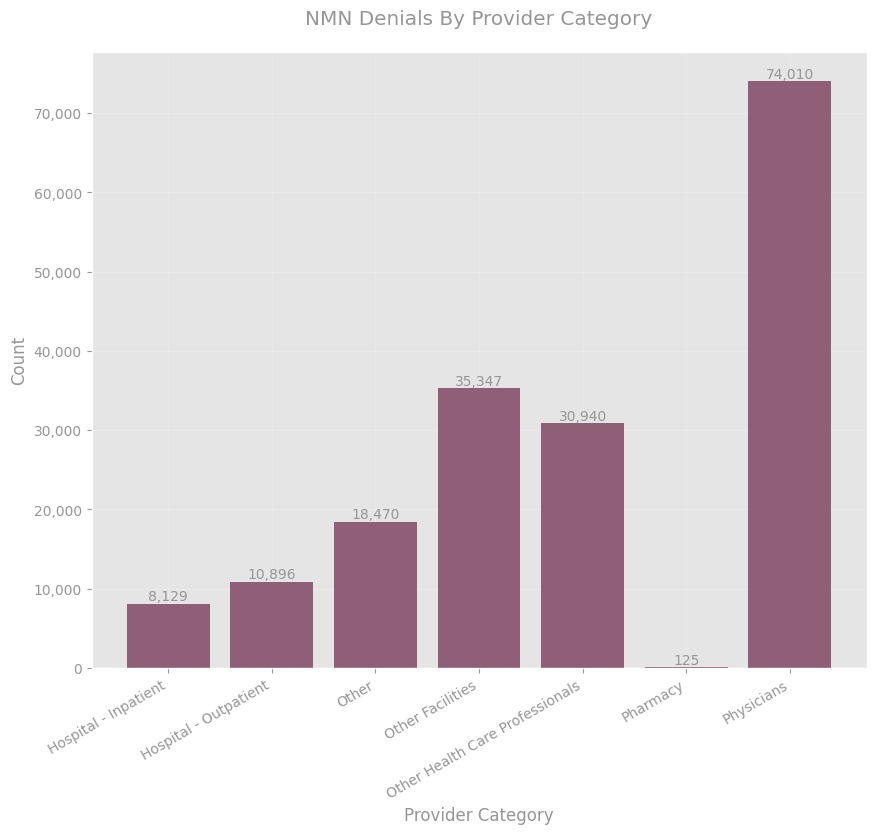

In [33]:
bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["claims_denied_nmn_exp"].values)
title = f"NMN Denials By Provider Category"
val_axis_label = "Count"
cat_axis_label = "Provider Category"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_denials_by_provider_cat.png"),
    figsize=(10, 8),
)

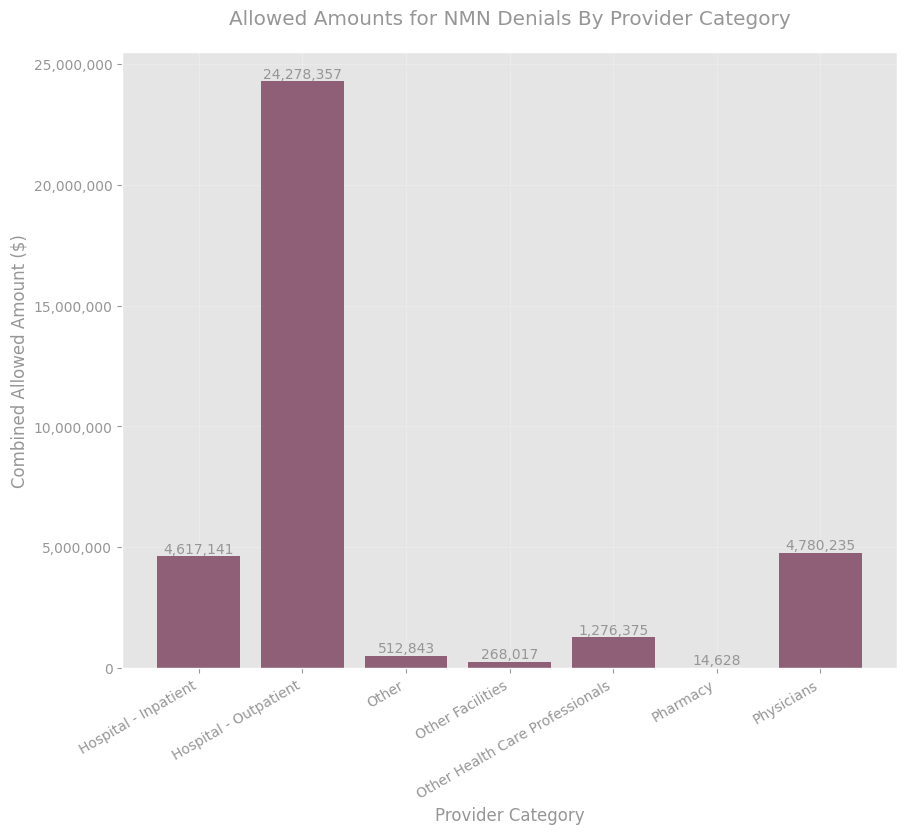

In [34]:
bar_names = list(provider_agg["provider_category"].values)
bar_vals = list(provider_agg["claims_denied_nmn_allowed"].values)
title = f"Allowed Amounts for NMN Denials By Provider Category"
val_axis_label = "Combined Allowed Amount ($)"
cat_axis_label = "Provider Category"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_allowed_amts_by_provider_cat.png"),
    figsize=(10, 8),
)

### Denial Rates by Insurer and category

In [53]:
# Inspect top k insurers (by claims adjudicated)
k = 5
top_k_insurers = insurer_agg.sort_values(by="claims_adjudicated", ascending=False).head(
    k
)

In [54]:
insurer_cats = list(top_k_insurers["insurer_name"].values)
denial_rates = list(top_k_insurers["denial_rate"].values)
appeal_rates = list(top_k_insurers["internal_appeal_rate"].values)
appeal_success_rates = list(top_k_insurers["internal_appeal_success_rate"].values)

In [55]:
# TODO: This will break if one changes k; temp fix to make plots legible
insurer_cats
abbrev_insurer_cats = [
    "Empire",
    "EHPI",
    "Oxford",
    "Excellus",
    "Highmark BCBS",
    # "Aetna",
    # "HIP",
    # "Cigna",
    # "UnitedHealthcare",
    # "Fidelis ",
]

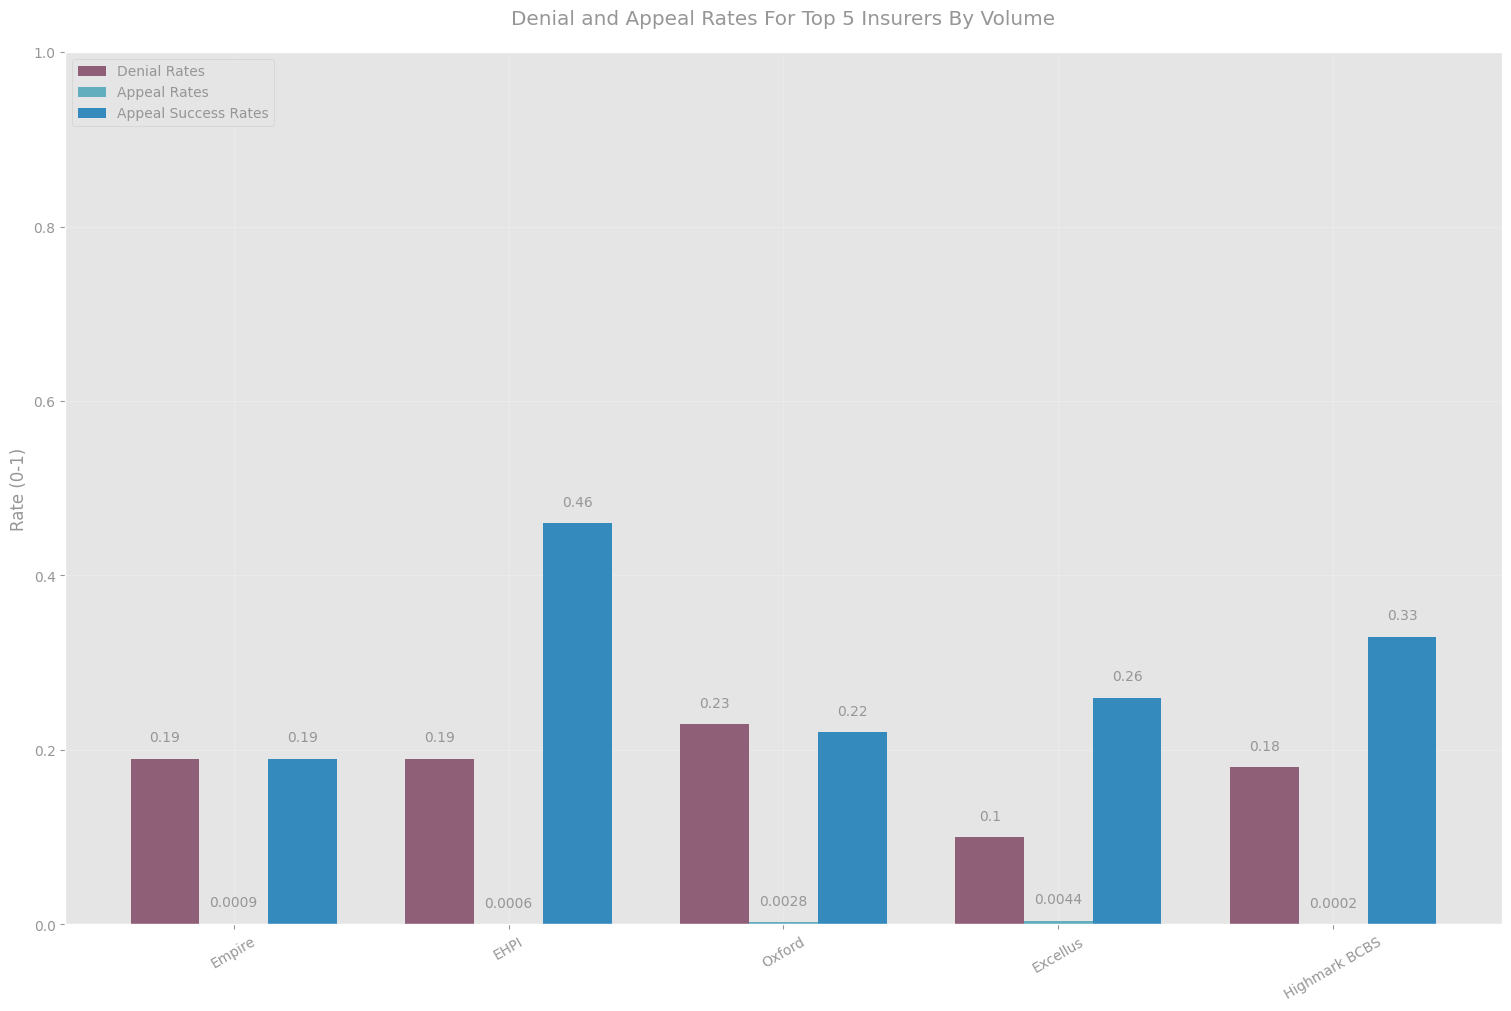

In [56]:
insurer_cat_rates = {
    "Denial Rates": [round(x, 2) for x in denial_rates],
    "Appeal Rates": [round(x, 4) for x in appeal_rates],
    "Appeal Success Rates": [round(x, 2) for x in appeal_success_rates],
}

x = np.arange(len(abbrev_insurer_cats))  # label locations
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(15, 10))

for attribute, measurement in insurer_cat_rates.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=10)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Rate (0-1)")
ax.set_title("Denial and Appeal Rates For 5 Insurers With Highest Claims Volume")
ax.set_xticks(x + width, abbrev_insurer_cats, rotation=30)
ax.legend(loc="upper left", ncols=1)
ax.set_ylim(0, 1)

plt.show()

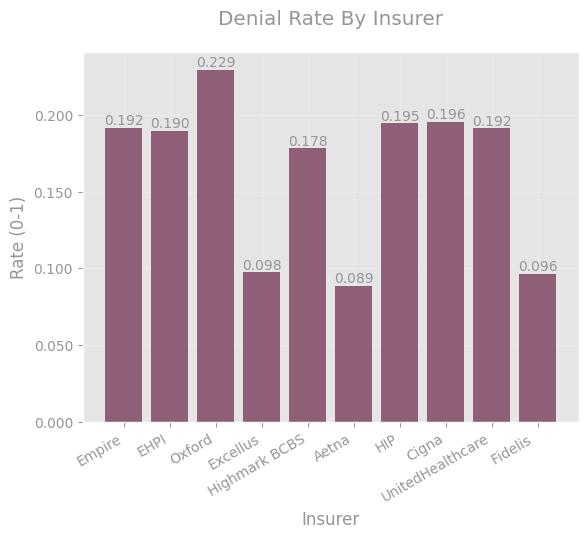

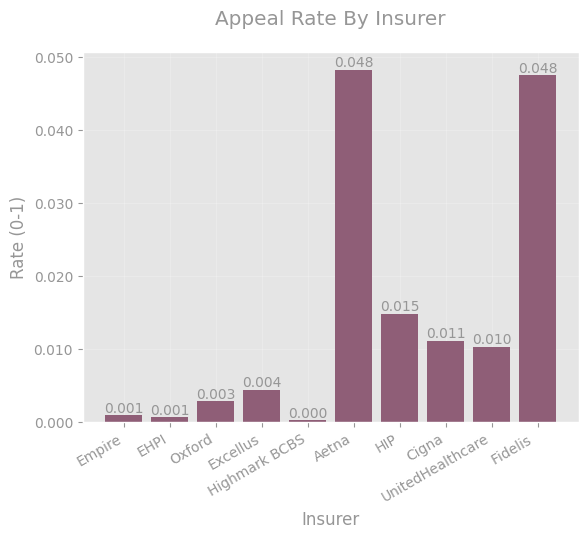

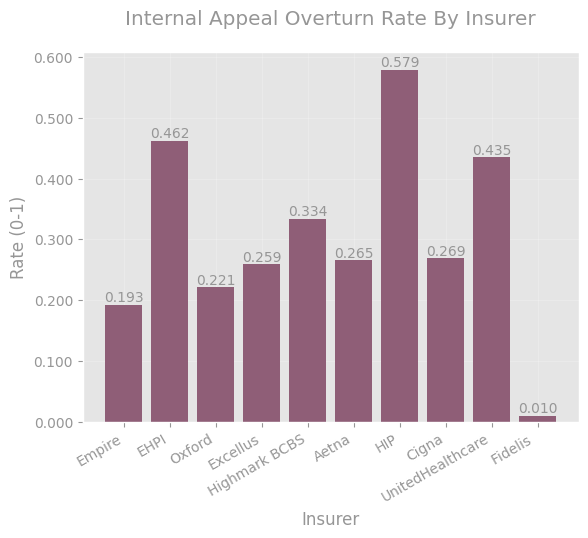

In [32]:
# Illegible, plot individually:
# Split out as three bar plots, above is ugly

bar_names = abbrev_insurer_cats
bar_vals = [round(x, 6) for x in denial_rates]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Denial Rate By Insurer"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
)


bar_names = abbrev_insurer_cats
bar_vals = [round(x, 6) for x in appeal_rates]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Appeal Rate By Insurer"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "appeal_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
)


bar_names = abbrev_insurer_cats
bar_vals = [round(x, 6) for x in appeal_success_rates]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Internal Appeal Overturn Rate By Insurer"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_overturn_rate_by_insurer.png"
    ),
    bar_label=True,
    int_vals=False,
)

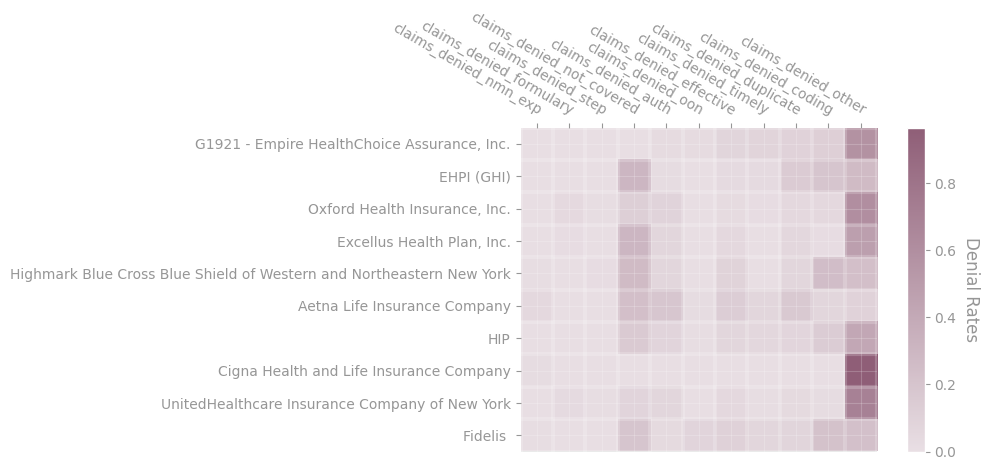

In [33]:
# Heatmap of denial rate types by insurer
denial_type_cats = [
    "claims_denied_nmn_exp",
    "claims_denied_formulary",
    "claims_denied_step",
    "claims_denied_not_covered",
    "claims_denied_auth",
    "claims_denied_oon",
    "claims_denied_effective",
    "claims_denied_timely",
    "claims_denied_duplicate",
    "claims_denied_coding",
    "claims_denied_other",
]
insurers_col = "insurer_name"
total_denials_col = "claims_denied_t3"
insurer_list = list(top_k_insurers[insurers_col].values)

col1 = "insurer_name"
arr = np.zeros((len(insurer_list), len(denial_type_cats)))
for idx, row in top_k_insurers.iterrows():
    try:
        row_idx = insurer_list.index(row[insurers_col])
        for col_idx, col in enumerate(denial_type_cats):
            denial_frac = row[col] / row[total_denials_col]
            arr[row_idx, col_idx] = denial_frac
    except ValueError as e:
        pass

fig, ax = plt.subplots(figsize=(10, 10))

heat_val_name = f"Denial Rates"
im, cbar = heatmap(
    arr,
    insurer_list,
    denial_type_cats,
    ax=ax,
    cmap=PRIMARY_CMAP,
    cbarlabel=heat_val_name,
    cbar_kw={"shrink": 0.3},
)
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "insurer_vs_denial_cat.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

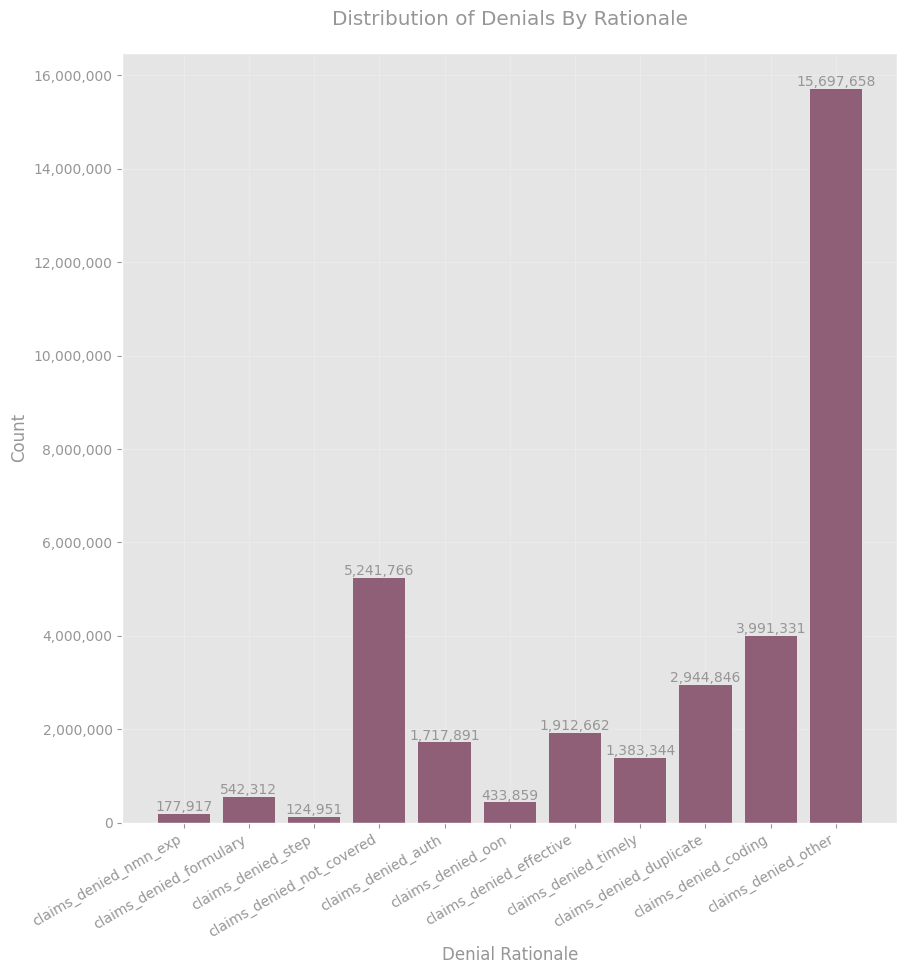

In [34]:
# Distribution of Denial Rate Types in General
denial_types = [
    "claims_denied_nmn_exp",
    "claims_denied_formulary",
    "claims_denied_step",
    "claims_denied_not_covered",
    "claims_denied_auth",
    "claims_denied_oon",
    "claims_denied_effective",
    "claims_denied_timely",
    "claims_denied_duplicate",
    "claims_denied_coding",
    "claims_denied_other",
]
bar_vals = [df[col].sum() for col in denial_types]
bar_names = denial_types
title = f"Distribution of Denials By Rationale"
val_axis_label = "Count"
cat_axis_label = "Denial Rationale"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    figsize=(10, 10),
)

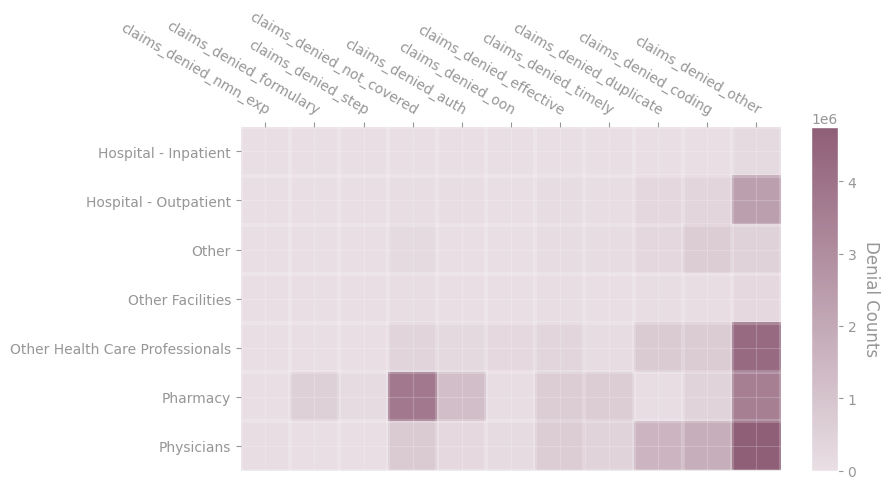

In [35]:
# Heatmap of denial rate types by provider cat types

denial_type_cats = [
    "claims_denied_nmn_exp",
    "claims_denied_formulary",
    "claims_denied_step",
    "claims_denied_not_covered",
    "claims_denied_auth",
    "claims_denied_oon",
    "claims_denied_effective",
    "claims_denied_timely",
    "claims_denied_duplicate",
    "claims_denied_coding",
    "claims_denied_other",
]
provider_categories = list(provider_agg["provider_category"].values)

arr = np.zeros((len(provider_categories), len(denial_type_cats)))
for idx, row in provider_agg.iterrows():
    try:
        row_idx = provider_categories.index(row["provider_category"])
        for col_idx, col in enumerate(denial_type_cats):
            denial_count = row[col]
            arr[row_idx, col_idx] = denial_count
    except ValueError as e:
        pass

fig, ax = plt.subplots(figsize=(9, 9))

heat_val_name = "Denial Counts"
im, cbar = heatmap(
    arr,
    provider_categories,
    denial_type_cats,
    ax=ax,
    cmap=PRIMARY_CMAP,
    cbarlabel=heat_val_name,
    cbar_kw={"shrink": 0.3},
)
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

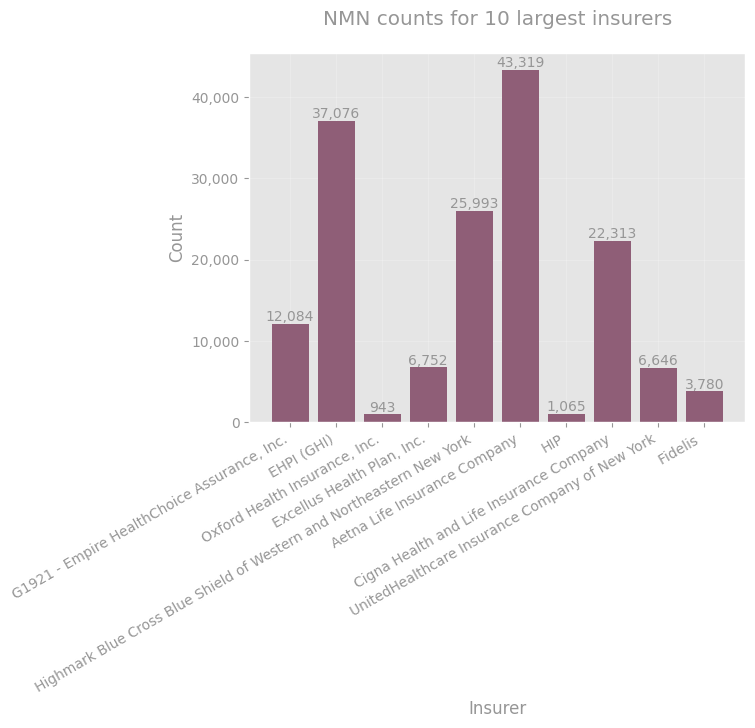

In [36]:
# Top k insurers NMN counts
bar_names = list(top_k_insurers["insurer_name"].values)
bar_vals = list(top_k_insurers["claims_denied_nmn_exp"].values)

title = f"NMN counts for {k} largest insurers"
val_axis_label = "Count"
cat_axis_label = "Insurer"

plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
)

In [37]:
# NMN specific denial rates, appeal rates, and appeal success rates

# Add overall NMN denial rate by provider category, by insurer
df["nmn_denial_rate"] = df["claims_denied_nmn_exp"] / df["claims_adjudicated"]

# Calculate NMN denial rate, by provider category, summed across insurers

total_adjudicated = df["claims_adjudicated"].sum()
total_denied = df["claims_denied_nmn_exp"].sum()
total_denial_rate = total_denied / total_adjudicated
print(
    f"Aggregate NMN denial rate across all insurers (summed counts): {100*total_denial_rate:.2f}%"
)

# Appeal, overturn rate for NMN? Data insufficient to determine that.
# Estimate from other sources where we know NMN appeal and overturn rates, and use for cost estimate?

Aggregate NMN denial rate across all insurers (summed counts): 0.12%


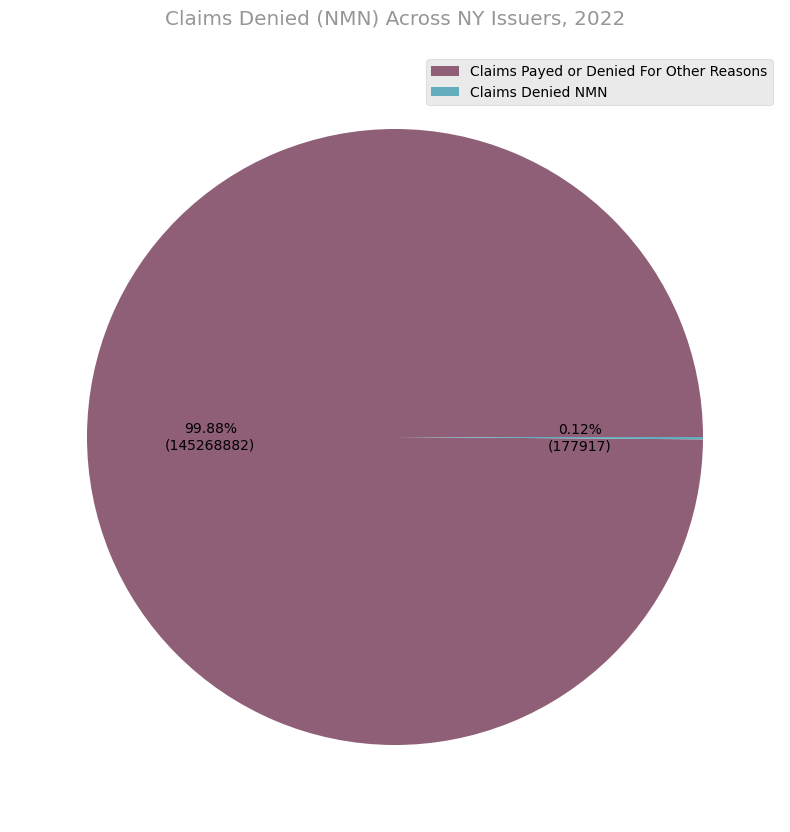

In [38]:
# Initial NMN denial rate
plot_pie(
    slice_names=["Claims Payed or Denied For Other Reasons", "Claims Denied NMN"],
    slice_vals=[total_adjudicated - total_denied, total_denied],
    title="Claims Denied (NMN) Across NY Issuers, 2022",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_nmn_denial_pie.png"),
)

In [39]:
# Scaling all appeals (monetary slider)
# Scaling NMN appeals (monetary slider)